In this project, we will be working on weather forecasting. The dataset has been obtained from the following url:https://www.kaggle.com/grubenm/austin-weather

In [0]:
#commenting the below 2 lines as it contains information related to my Google account
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os, shutil
from math import ceil, floor
from fbprophet import Prophet
import seaborn as sns
import matplotlib.ticker as ticker

In [0]:
def unzip_files(zipFilePath, unzip_directory):
  zipFile = ZipFile(zipFilePath, 'r')
  zipFile.extractall(unzip_directory)
  zipFile.close()

In [0]:
unzip_files('drive/My Drive/datasets/weather/austin-weather.zip', 'Unzipped_austin_weather_data')

In [0]:
main_df = pd.read_csv('Unzipped_austin_weather_data/austin_weather.csv')

In [6]:
main_df.head(15)

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,29.86,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,30.41,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,30.56,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,30.56,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,30.41,30.33,30.27,10,10,7,10,2,16,T,
5,2013-12-26,57,48,39,39,36,33,79,63,47,30.47,30.4,30.34,10,9,7,12,3,17,0,
6,2013-12-27,60,53,45,41,39,37,83,65,47,30.46,30.39,30.34,10,9,7,7,1,11,T,
7,2013-12-28,62,51,40,43,39,33,92,64,36,30.33,30.17,30.04,10,10,7,10,2,14,T,
8,2013-12-29,64,50,36,49,41,28,92,76,60,30.31,30.1,29.99,10,10,4,17,5,24,0,
9,2013-12-30,44,40,35,31,26,21,75,60,45,30.44,30.33,30.26,10,10,10,13,5,21,0,


In [7]:
main_df.tail()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
1314,2017-07-27,103,89,75,71,67,61,82,54,25,30.04,29.97,29.88,10,10,10,12,5,21,0,
1315,2017-07-28,105,91,76,71,64,55,87,54,20,29.97,29.9,29.81,10,10,10,14,5,20,0,
1316,2017-07-29,107,92,77,72,64,55,82,51,19,29.91,29.86,29.79,10,10,10,12,4,17,0,
1317,2017-07-30,106,93,79,70,68,63,69,48,27,29.96,29.91,29.87,10,10,10,13,4,20,0,
1318,2017-07-31,99,88,77,66,61,54,64,43,22,30.04,29.97,29.91,10,10,10,12,4,20,0,


In [8]:
len(main_df)

1319

In [9]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 21 columns):
Date                          1319 non-null object
TempHighF                     1319 non-null int64
TempAvgF                      1319 non-null int64
TempLowF                      1319 non-null int64
DewPointHighF                 1319 non-null object
DewPointAvgF                  1319 non-null object
DewPointLowF                  1319 non-null object
HumidityHighPercent           1319 non-null object
HumidityAvgPercent            1319 non-null object
HumidityLowPercent            1319 non-null object
SeaLevelPressureHighInches    1319 non-null object
SeaLevelPressureAvgInches     1319 non-null object
SeaLevelPressureLowInches     1319 non-null object
VisibilityHighMiles           1319 non-null object
VisibilityAvgMiles            1319 non-null object
VisibilityLowMiles            1319 non-null object
WindHighMPH                   1319 non-null object
WindAvgMPH                   

In this project we are primarily going to analyse the average values of temperature, dew point, humidity, wind, visibility, sea level pressure.

In [14]:
main_df.dtypes

Date                          object
TempHighF                      int64
TempAvgF                       int64
TempLowF                       int64
DewPointHighF                 object
DewPointAvgF                  object
DewPointLowF                  object
HumidityHighPercent           object
HumidityAvgPercent            object
HumidityLowPercent            object
SeaLevelPressureHighInches    object
SeaLevelPressureAvgInches     object
SeaLevelPressureLowInches     object
VisibilityHighMiles           object
VisibilityAvgMiles            object
VisibilityLowMiles            object
WindHighMPH                   object
WindAvgMPH                    object
WindGustMPH                   object
PrecipitationSumInches        object
Events                        object
dtype: object

we will be analysing the temperature in celsius, so we need to create a new column containing the celsius values

In [0]:
main_df['TempAvgC'] = main_df.apply(lambda row: (5.0/9)*(row['TempAvgF'] - 32), axis=1)

In [16]:
main_df[['TempAvgF', 'TempAvgC']].head()

,TempAvgF,TempAvgC
0,60,15.555556
1,48,8.888889
2,45,7.222222
3,46,7.777778
4,50,10.000000


In [0]:
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%Y-%m-%d')

In [0]:
df_temperature = main_df[['Date','TempAvgC']]

In [19]:
df_temperature.head()

,Date,TempAvgC
0,2013-12-21,15.555556
1,2013-12-22,8.888889
2,2013-12-23,7.222222
3,2013-12-24,7.777778
4,2013-12-25,10.000000


In [20]:
df_temperature.tail()

,Date,TempAvgC
1314,2017-07-27,31.666667
1315,2017-07-28,32.777778
1316,2017-07-29,33.333333
1317,2017-07-30,33.888889
1318,2017-07-31,31.111111


In [0]:
#we need to rename the columns to ds and y, as fbprophet expects a dataframe in this form
df_temperature.columns = ['ds','y']

In [22]:
df_temperature.head()

,ds,y
0,2013-12-21,15.555556
1,2013-12-22,8.888889
2,2013-12-23,7.222222
3,2013-12-24,7.777778
4,2013-12-25,10.000000


we will split the dataset into train and test, in order to evaluate the forecasting capability of the model

In [0]:
df_temp_train = df_temperature.iloc[0:1199]
df_temp_test = df_temperature.iloc[1199:]

In [24]:
len(df_temp_train)

1199

In [25]:
len(df_temp_test)

120

In [26]:
df_temp_train.tail()

,ds,y
1194,2017-03-29,22.222222
1195,2017-03-30,20.000000
1196,2017-03-31,21.666667
1197,2017-04-01,21.666667
1198,2017-04-02,19.444444


In [27]:
df_temp_test.head()

,ds,y
1199,2017-04-03,21.111111
1200,2017-04-04,23.888889
1201,2017-04-05,17.777778
1202,2017-04-06,17.777778
1203,2017-04-07,19.444444


In [28]:
model_temp = Prophet()
model_temp.fit(df_temp_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future_temp = model_temp.make_future_dataframe(periods=120)
future_temp.tail()

,ds
1314,2017-07-27
1315,2017-07-28
1316,2017-07-29
1317,2017-07-30
1318,2017-07-31


In [0]:
forecast_temp = model_temp.predict(future_temp)

In [31]:
forecast_temp.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [32]:
len(forecast_temp)

1319

In [33]:
forecast_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1309,2017-07-22,33.761410,29.109432,38.476600
1310,2017-07-23,33.804838,29.131916,38.358751
1311,2017-07-24,33.986918,29.132560,39.016339
1312,2017-07-25,34.042649,28.676883,38.973088
1313,2017-07-26,33.990228,28.825705,38.712382
1314,2017-07-27,33.953981,29.501620,39.123624
1315,2017-07-28,33.795060,28.915977,38.781029
1316,2017-07-29,33.818569,29.137381,38.474593
1317,2017-07-30,33.840013,28.875551,38.818163
1318,2017-07-31,34.005547,28.990669,38.984266


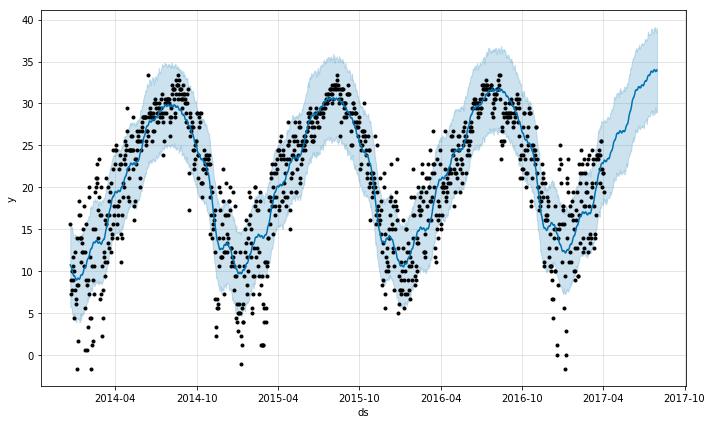

In [34]:
plot1 = model_temp.plot(forecast_temp)

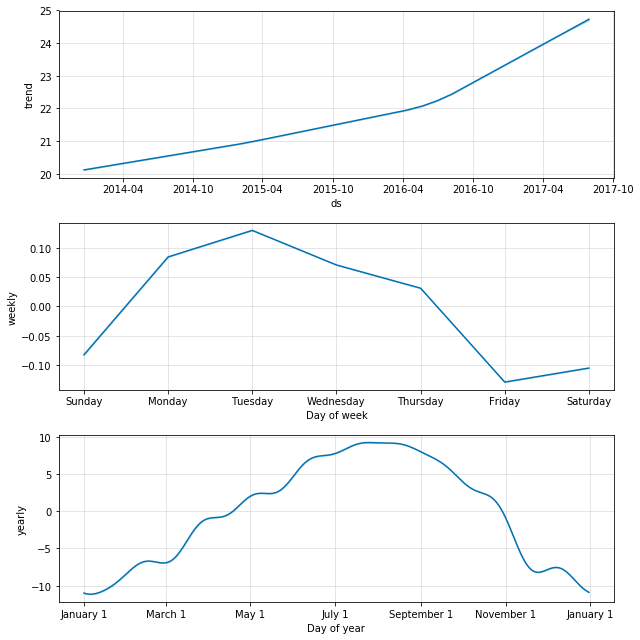

In [35]:
plot2 = model_temp.plot_components(forecast_temp)

In [0]:
analyse_temp_forecast_df = pd.concat([df_temp_test, forecast_temp[1199:]['yhat']], axis=1)

In [37]:
analyse_temp_forecast_df.tail()

,ds,y,yhat
1314,2017-07-27,31.666667,33.953981
1315,2017-07-28,32.777778,33.795060
1316,2017-07-29,33.333333,33.818569
1317,2017-07-30,33.888889,33.840013
1318,2017-07-31,31.111111,34.005547


In [0]:
analyse_temp_forecast_df.set_index('ds', inplace=True)

In [39]:
analyse_temp_forecast_df.tail()

,y,yhat
ds,,
2017-07-27,31.666667,33.953981
2017-07-28,32.777778,33.795060
2017-07-29,33.333333,33.818569
2017-07-30,33.888889,33.840013
2017-07-31,31.111111,34.005547


In [0]:
def create_line_charts(df, title, xlabel, ylabel):
  ax = sns.lineplot(data=df)
  ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
  for xtick in ax.get_xticklabels():
    xtick.set_rotation(45)
  

In [0]:
sns.set(rc={'figure.figsize':(17,8)})

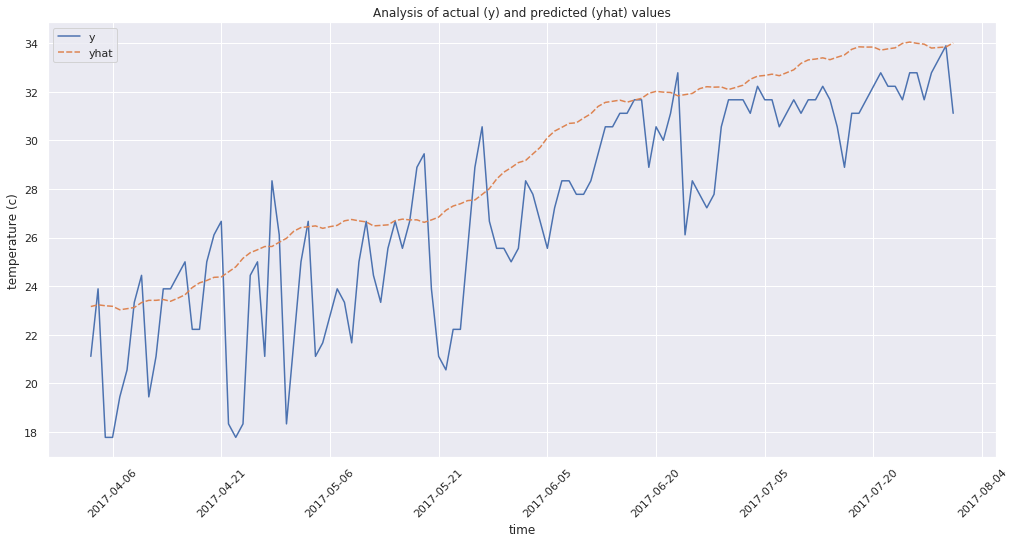

In [42]:
create_line_charts(analyse_temp_forecast_df, 'Analysis of actual (y) and predicted (yhat) values', 'time', 'temperature (c)')

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
mean_absolute_error(analyse_temp_forecast_df['y'], analyse_temp_forecast_df['yhat'])

2.354099668103568

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
root_mean_squared_error(analyse_temp_forecast_df['y'], analyse_temp_forecast_df['yhat'])

2.9281635812117597

Now if we want we can predict into the future, by passing the entire dataframe

In [47]:
model_temp2 = Prophet()
model_temp2.fit(df_temperature)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future_temp2 = model_temp2.make_future_dataframe(periods=180)
future_temp2.tail()

,ds
1494,2018-01-23
1495,2018-01-24
1496,2018-01-25
1497,2018-01-26
1498,2018-01-27


In [0]:
forecast_temp2 = model_temp2.predict(future_temp2)

In [50]:
forecast_temp2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1489,2018-01-18,13.593993,8.720838,18.487503
1490,2018-01-19,13.645530,9.172104,18.194594
1491,2018-01-20,13.675495,9.028063,18.357736
1492,2018-01-21,13.779333,9.159040,18.317281
1493,2018-01-22,14.024607,9.454212,18.982896
1494,2018-01-23,14.275174,9.284876,18.647014
1495,2018-01-24,14.391227,9.725783,18.865576
1496,2018-01-25,14.536556,9.769280,19.161901
1497,2018-01-26,14.630992,10.000147,19.351273
1498,2018-01-27,14.702208,9.946004,19.697781


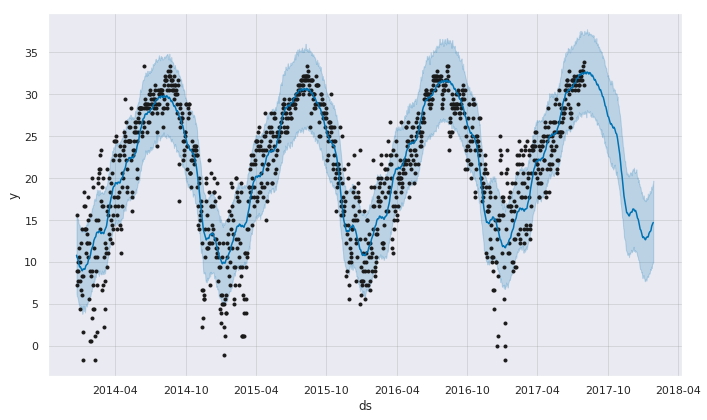

In [51]:
plot3 = model_temp2.plot(forecast_temp2)

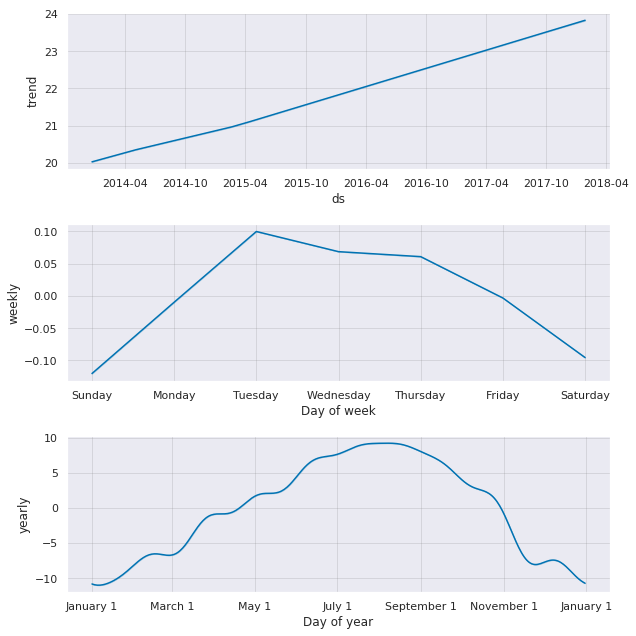

In [52]:
plot4 = model_temp2.plot_components(forecast_temp2)

In [0]:
df_humidity = main_df[['Date', 'HumidityAvgPercent']]

In [54]:
df_humidity.head()

,Date,HumidityAvgPercent
0,2013-12-21,75
1,2013-12-22,68
2,2013-12-23,52
3,2013-12-24,56
4,2013-12-25,71


In [55]:
len(df_humidity)

1319

In [0]:
df_humidity = df_humidity[df_humidity['HumidityAvgPercent'] != '-']

In [61]:
df_humidity.astype({'HumidityAvgPercent':'float64'})

,Date,HumidityAvgPercent
0,2013-12-21,75.0
1,2013-12-22,68.0
2,2013-12-23,52.0
3,2013-12-24,56.0
4,2013-12-25,71.0
5,2013-12-26,63.0
6,2013-12-27,65.0
7,2013-12-28,64.0
8,2013-12-29,76.0
9,2013-12-30,60.0


In [0]:
df_humidity.columns = ['ds', 'y']

In [63]:
df_humidity.head()

,ds,y
0,2013-12-21,75
1,2013-12-22,68
2,2013-12-23,52
3,2013-12-24,56
4,2013-12-25,71


In [0]:
df_humidity_train = df_humidity.iloc[0:1227]
df_humidity_test = df_humidity.iloc[1227:]

In [85]:
df_humidity_train.tail()

,ds,y
1224,2017-04-28,64
1225,2017-04-29,64
1226,2017-04-30,43
1227,2017-05-01,50
1228,2017-05-02,57


In [86]:
df_humidity_test.head()

,ds,y
1229,2017-05-03,66
1230,2017-05-04,43
1231,2017-05-05,44
1232,2017-05-06,52
1233,2017-05-07,56


In [87]:
model_humidity = Prophet()
model_humidity.fit(df_humidity_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
future_humidity = model_humidity.make_future_dataframe(periods=90)
future_humidity.tail()

,ds
1312,2017-07-27
1313,2017-07-28
1314,2017-07-29
1315,2017-07-30
1316,2017-07-31


In [0]:
forecast_humidity = model_humidity.predict(future_humidity)

In [90]:
forecast_humidity[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1307,2017-07-22,64.205492,50.942214,78.549722
1308,2017-07-23,64.608647,49.176631,79.649479
1309,2017-07-24,62.195084,48.084563,78.061675
1310,2017-07-25,61.892488,47.583349,77.434847
1311,2017-07-26,61.427821,47.201144,77.353177
1312,2017-07-27,61.917154,46.954402,75.807170
1313,2017-07-28,62.038704,47.628140,78.044931
1314,2017-07-29,64.775591,49.985690,79.629637
1315,2017-07-30,65.449091,50.655607,80.876539
1316,2017-07-31,63.255697,48.428385,76.721717


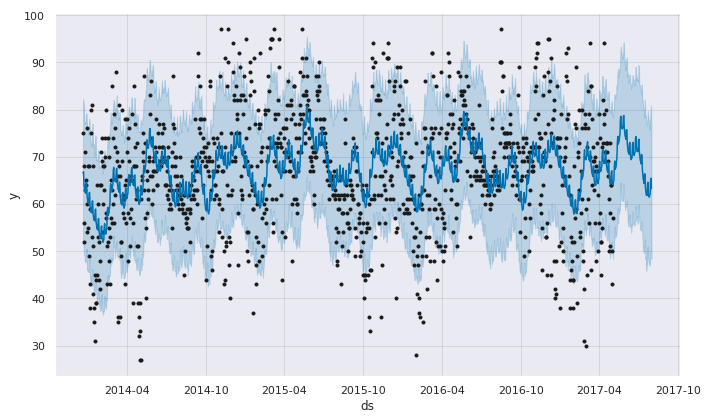

In [91]:
plot_humidity1 = model_humidity.plot(forecast_humidity)

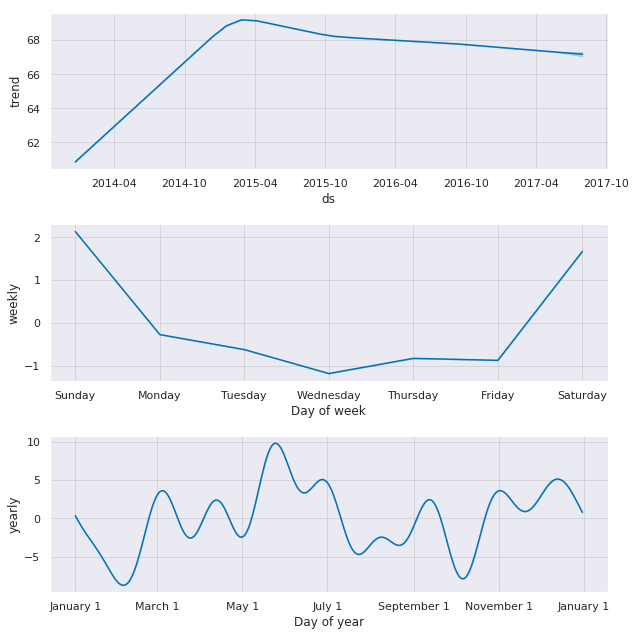

In [92]:
plot_humidity2 = model_humidity.plot_components(forecast_humidity)

In [128]:
analyse_humidity_forecast_df = pd.concat([df_humidity_test.reset_index(), forecast_humidity[1227:]['yhat'].reset_index()], axis=1)
analyse_humidity_forecast_df = analyse_humidity_forecast_df[['ds','y', 'yhat']]
analyse_humidity_forecast_df.set_index('ds', inplace=True)
analyse_humidity_forecast_df.tail()

,y,yhat
ds,,
2017-07-27,54,61.917154
2017-07-28,54,62.038704
2017-07-29,51,64.775591
2017-07-30,48,65.449091
2017-07-31,43,63.255697


In [129]:
analyse_humidity_forecast_df.dtypes

y        object
yhat    float64
dtype: object

In [0]:
analyse_humidity_forecast_df['y'] = analyse_humidity_forecast_df['y'].map(pd.to_numeric)

In [131]:
analyse_humidity_forecast_df.dtypes

y         int64
yhat    float64
dtype: object

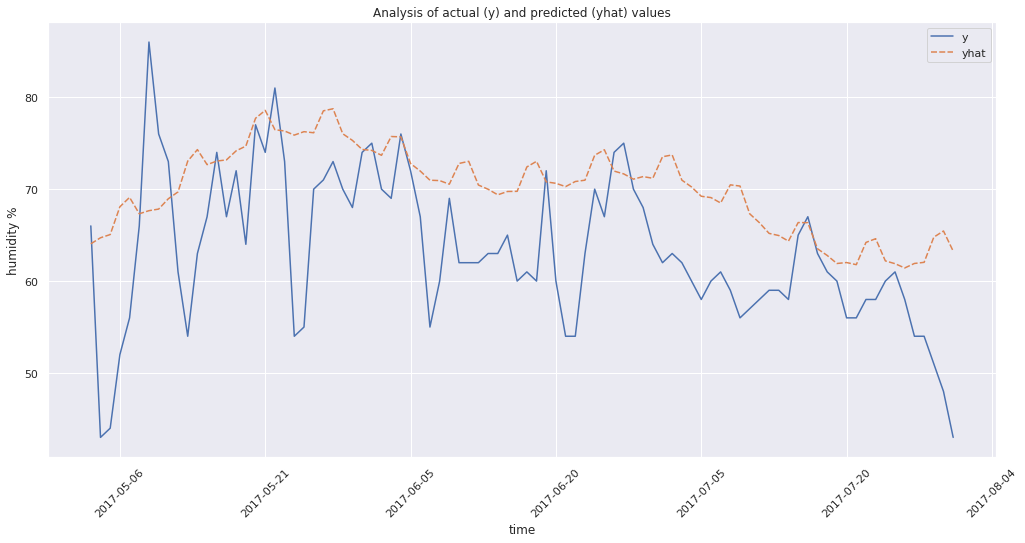

In [132]:
create_line_charts(analyse_humidity_forecast_df, 'Analysis of actual (y) and predicted (yhat) values', 'time', 'humidity %')

In [133]:
mean_absolute_error(analyse_humidity_forecast_df['y'], analyse_humidity_forecast_df['yhat'])

7.8443223004430465

In [134]:
root_mean_squared_error(analyse_humidity_forecast_df['y'], analyse_humidity_forecast_df['yhat'])

9.668386306946427